Students: Alice Schiavone, KidaraLOL

# Env Set up

In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!pip install pyspark
!pip install -q findspark
!pip show pyspark
!pip install memory_profiler
%load_ext memory_profiler

     |████████████████████████████████| 281.3 MB 36 kB/s 
     |████████████████████████████████| 198 kB 60.9 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.0-py2.py3-none-any.whl size=281805912 sha256=8f290b02f4c249afd745dd80d5005123301c2fe096d89c143f092f3471671739
  Stored in directory: /root/.cache/pip/wheels/0b/de/d2/9be5d59d7331c6c2a7c1b6d1a4f463ce107332b1ecd4e80718
Successfully built pyspark
Name: pyspark
Version: 3.2.0
Summary: Apache Spark Python API
Home-page: https://github.com/apache/spark/tree/master/python
Author: Spark Developers
Author-email: dev@spark.apache.org
License: http://www.apache.org/licenses/LICENSE-2.0
Location: /usr/local/lib/python3.7/dist-packages
Requires: py4j
Required-by: 
  Created wheel for memory-profiler: filename=memory_profiler-0.58.0-py3-none-any.whl size=30190 sha256=fe37f81d4c8671e493fb98468c0ffc886054f95f70020342b60642fe635c9b05
  Stored in directory: /root/.cache/pip/wheels/56/19/d5/8cad06661aec65a04a0d6785b1a5ad035cb645b1772a4a0882


In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/usr/local/lib/python3.7/dist-packages/pyspark"

import pyspark
sc = pyspark.SparkContext("local[*]").getOrCreate()
sc

<SparkContext master=local[*] appName=pyspark-shell>

In [3]:
import findspark
findspark.init()

# Text Choice and Pre-processing
I will compute the similarities between [Shakespeare comedies](http://shakespeare.mit.edu/). 





In [4]:
!wget https://github.com/aliswh/architectures-for-big-data/raw/main/data/comedies.zip
!mkdir /content/comedies
!unzip /content/comedies.zip -d /content/comedies

--2021-11-19 18:28:34--  https://github.com/aliswh/architectures-for-big-data/raw/main/data/comedies.zip
Resolving github.com (github.com)... 13.114.40.48
Connecting to github.com (github.com)|13.114.40.48|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/aliswh/architectures-for-big-data/main/data/comedies.zip [following]
--2021-11-19 18:28:35--  https://raw.githubusercontent.com/aliswh/architectures-for-big-data/main/data/comedies.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2509186 (2.4M) [application/zip]
Saving to: ‘comedies.zip’

comedies.zip        100%[===================>]   2.39M  --.-KB/s    in 0.08s   

2021-11-19 18:28:36 (30.1 MB/s) - ‘comedies.zip’ saved [2509186/2509186]

A

In [5]:
import os
data_path = '/content/comedies/'
f"Total number of texts: {len(os.listdir(data_path))}"

'Total number of texts: 17'

In [6]:
import re

stem = '[0-9]*[!@#$%^&*_+=\-;:,.—<>?\'\/\\\ "()\[\]]+'

for text in os.listdir(data_path):
  text_name = re.sub(stem, '', text)
  file_path = data_path + text_name
  os.rename(data_path + text, file_path) 

rdd_texts = sc.wholeTextFiles(data_path) # create RDD

def rename_texts(x):
  return re.sub('file:'+data_path, '', x)
def clean_text(x):
  return re.sub(stem, ' ', x).lower()

rdd_texts = rdd_texts.map(lambda x: (rename_texts(x[0]), clean_text(x[1]) ) )\
  .map(lambda x: (x[0], x[1].split()))
rdd_texts.count()

17

# Solution

## Histogram

In [7]:
rdd_occurences = rdd_texts.flatMap(lambda x: [((x[0],y),1) for y in x[1]]) # not distributed
rdd_occurences.take(3)

[(('TroilusandCressidatxt', 'shakespeare'), 1),
 (('TroilusandCressidatxt', 'troilus'), 1),
 (('TroilusandCressidatxt', 'and'), 1)]

In [8]:
rdd_occurences = rdd_texts.flatMapValues(lambda x: x).map(lambda x: (x,1)) # distributed
rdd_occurences.take(3)

[(('TroilusandCressidatxt', 'shakespeare'), 1),
 (('TroilusandCressidatxt', 'troilus'), 1),
 (('TroilusandCressidatxt', 'and'), 1)]

In [9]:
rdd_hist = rdd_occurences.reduceByKey(lambda x,y: x+y)
rdd_hist.take(3)

[(('TroilusandCressidatxt', 'shakespeare'), 2),
 (('TroilusandCressidatxt', 'troilus'), 376),
 (('TroilusandCressidatxt', 'cressida'), 327)]

## Visual histogram

In [10]:
N = 5
print(rdd_hist.map(lambda x : x[1]).histogram(N)) # pyspark implementation

([1.0, 194.2, 387.4, 580.5999999999999, 773.8, 967], [55039, 268, 77, 28, 8])


In [11]:
MAX = rdd_hist.map(lambda x : x[1]).max() + 1 
bins = {((i-1)*MAX//N, i*MAX//N):0 for i in range(1,N+1)} # Create N even intervals

sorted(rdd_hist.map(lambda x: [b for b in bins if x[1] in range (b[0],b[1]) ]).map(lambda x: (x[0],1)).reduceByKey(lambda x,y: x+y).collect())

[((0, 193), 55031),
 ((193, 387), 276),
 ((387, 580), 77),
 ((580, 774), 28),
 ((774, 968), 8)]

Most frequent word in a text: (('Cymbelinetxt', 'the'), 967)


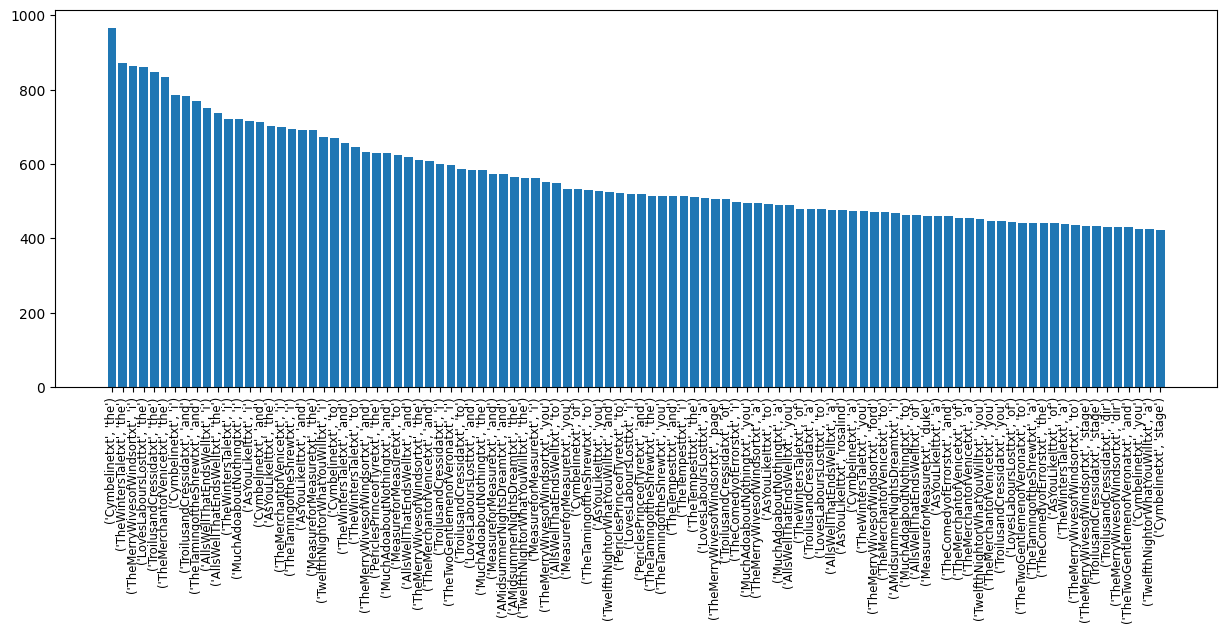

In [12]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

for_histogrom_rdd = rdd_hist.sortBy(lambda x: x[1], ascending=False)
print(f"Most frequent word in a text: {for_histogrom_rdd.first()}") # just to check if the plot is correct

data = for_histogrom_rdd.map(lambda x: x[0]).take(100)
labels = for_histogrom_rdd.map(lambda x: x[1]).take(100)

figure(figsize=(15, 5), dpi=100)
plt.bar(range(len(labels)), labels)
plt.xticks(range(len(data)), data, rotation='vertical', size='small')
plt.show()

## More pre-processing: computing TF.IDF


Term Frequency
> Occurence of term w.r.t. the most frequent term in the document

In [13]:
rdd_hist.first()

(('TroilusandCressidatxt', 'shakespeare'), 2)

In [14]:
MAX_tf = rdd_hist.map(lambda x: (x[0][0],x[0][1],x[1])).map(lambda x: (x[1],x[2])).reduceByKey(lambda x,y: x+y).map(lambda x: x[1]).max()
tf_rdd = rdd_hist.map(lambda x: (x[0], x[1]/MAX_tf))
tf_rdd.take(10)

[(('TroilusandCressidatxt', 'shakespeare'), 0.00017632019747862118),
 (('TroilusandCressidatxt', 'troilus'), 0.03314819712598078),
 (('TroilusandCressidatxt', 'cressida'), 0.02882835228775456),
 (('TroilusandCressidatxt', 'online'), 8.816009873931059e-05),
 (('TroilusandCressidatxt', 'library'), 8.816009873931059e-05),
 (('TroilusandCressidatxt', 'of'), 0.044609009962091155),
 (('TroilusandCressidatxt', 'oll'), 8.816009873931059e-05),
 (('TroilusandCressidatxt', 'libertyfund'), 8.816009873931059e-05),
 (('TroilusandCressidatxt', 'org'), 8.816009873931059e-05),
 (('TroilusandCressidatxt', 'version'), 8.816009873931059e-05)]

Inverse Document Frequency
> For each term, divide the total number of documents by the number of documents that contain that term

In [15]:
from math import log 

N_docs = rdd_hist.map(lambda x: (x[0][0])).distinct().count()

idf_rdd = tf_rdd.map(lambda x: (x[0][1], (x[0][0], x[1], 1)) )\
                .map(lambda x: (x[0], x[1][2]))\
                .reduceByKey(lambda x,y: x+y)\
                .map(lambda x: (x[0], log(N_docs / x[1] )) )

idf_rdd.take(10)

[('shakespeare', 0.0),
 ('troilus', 1.0414538748281612),
 ('cressida', 2.1400661634962708),
 ('online', 0.0),
 ('library', 0.0),
 ('of', 0.0),
 ('oll', 0.0),
 ('libertyfund', 0.0),
 ('org', 0.0),
 ('version', 0.0)]

In [16]:
tf_idf_rdd = tf_rdd.map(lambda x: (x[0][1], (x[0][0], x[1]) ) ).join(idf_rdd).map(lambda x: (x[0], (x[1][0][0], x[1][0][1] * x[1][1]) ) )
tf_idf_rdd.take(3)

[('library', ('TroilusandCressidatxt', 0.0)),
 ('library', ('MuchAdoaboutNothingtxt', 0.0)),
 ('library', ('TheWintersTaletxt', 0.0))]

In [17]:
tf_idf_rdd.map(lambda x : (x[0], x[1][1])).takeOrdered(10, key=lambda x: -x[1])

[('rosalind', 0.1188935512448875),
 ('ford', 0.11789444577224138),
 ('syr', 0.10090965273725745),
 ('antipholus', 0.09841188905564217),
 ('mrs', 0.09566434900586536),
 ('dromio', 0.09466524353321926),
 ('petruchio', 0.09266703258792704),
 ('proteus', 0.09066882164263479),
 ('berowne', 0.08817105796101951),
 ('benedick', 0.083675083334112)]

## Cosine similarity

In [18]:
term_key_rdd = rdd_hist.map(lambda x: (x[0][1], (x[0][0], x[1])))
term_key_rdd.take(3)

[('shakespeare', ('TroilusandCressidatxt', 2)),
 ('troilus', ('TroilusandCressidatxt', 376)),
 ('cressida', ('TroilusandCressidatxt', 327))]

In [19]:
inner_join_rdd = term_key_rdd.join(term_key_rdd)
inner_join_rdd.take(10)

[('library', (('TroilusandCressidatxt', 1), ('TroilusandCressidatxt', 1))),
 ('library', (('TroilusandCressidatxt', 1), ('MuchAdoaboutNothingtxt', 1))),
 ('library', (('TroilusandCressidatxt', 1), ('TheWintersTaletxt', 1))),
 ('library', (('TroilusandCressidatxt', 1), ('AMidsummerNightsDreamtxt', 1))),
 ('library', (('TroilusandCressidatxt', 1), ('LovesLaboursLosttxt', 1))),
 ('library', (('TroilusandCressidatxt', 1), ('TheMerryWivesofWindsortxt', 1))),
 ('library',
  (('TroilusandCressidatxt', 1), ('TheTwoGentlemenofVeronatxt', 1))),
 ('library', (('TroilusandCressidatxt', 1), ('TheMerchantofVenicetxt', 1))),
 ('library', (('TroilusandCressidatxt', 1), ('TheTamingoftheShrewtxt', 1))),
 ('library', (('TroilusandCressidatxt', 1), ('TheTempesttxt', 3)))]

In [20]:
def make_pairs(x):
    return ((x[1][0][0],x[1][1][0]),(x[1][0][1],x[1][1][1]))

doc_pairs_rdd = inner_join_rdd.filter(lambda x: x[1][0][0] != x[1][1][0]).map(lambda x: make_pairs(x))
doc_pairs_rdd.take(10)

[(('TroilusandCressidatxt', 'MuchAdoaboutNothingtxt'), (1, 1)),
 (('TroilusandCressidatxt', 'TheWintersTaletxt'), (1, 1)),
 (('TroilusandCressidatxt', 'AMidsummerNightsDreamtxt'), (1, 1)),
 (('TroilusandCressidatxt', 'LovesLaboursLosttxt'), (1, 1)),
 (('TroilusandCressidatxt', 'TheMerryWivesofWindsortxt'), (1, 1)),
 (('TroilusandCressidatxt', 'TheTwoGentlemenofVeronatxt'), (1, 1)),
 (('TroilusandCressidatxt', 'TheMerchantofVenicetxt'), (1, 1)),
 (('TroilusandCressidatxt', 'TheTamingoftheShrewtxt'), (1, 1)),
 (('TroilusandCressidatxt', 'TheTempesttxt'), (1, 3)),
 (('TroilusandCressidatxt', 'AsYouLikeIttxt'), (1, 1))]

In [21]:
cosine_sim_rdd = doc_pairs_rdd.mapValues(lambda x: (x[0]*x[1],x[0]*x[0],x[1]*x[1]))\
                              .reduceByKey(lambda x,y: (x[0]+y[0],x[1]+y[1],x[2]+y[2]))\
                              .mapValues(lambda x: x[0]/((x[1]**(1/2))*(x[2]**(1/2))))
cosine_sim_rdd.take(10)

[(('TroilusandCressidatxt', 'LovesLaboursLosttxt'), 0.945461051301803),
 (('MuchAdoaboutNothingtxt', 'LovesLaboursLosttxt'), 0.9220588236061651),
 (('TheWintersTaletxt', 'LovesLaboursLosttxt'), 0.9530832371273357),
 (('AMidsummerNightsDreamtxt', 'LovesLaboursLosttxt'), 0.9464803254932969),
 (('LovesLaboursLosttxt', 'TroilusandCressidatxt'), 0.945461051301803),
 (('LovesLaboursLosttxt', 'MuchAdoaboutNothingtxt'), 0.9220588236061651),
 (('LovesLaboursLosttxt', 'TheWintersTaletxt'), 0.9530832371273357),
 (('LovesLaboursLosttxt', 'AMidsummerNightsDreamtxt'), 0.9464803254932969),
 (('TheMerryWivesofWindsortxt', 'TheTamingoftheShrewtxt'), 0.9329042854396887),
 (('TheMerryWivesofWindsortxt', 'Cymbelinetxt'), 0.9041022630611331)]

In [22]:
best_cosine_rdd = cosine_sim_rdd.map(lambda x: (x[0][0],(x[0][1],x[1])))\
                                .sortByKey()
best_cosine_rdd.take(3)

[('AMidsummerNightsDreamtxt', ('LovesLaboursLosttxt', 0.9464803254932969)),
 ('AMidsummerNightsDreamtxt',
  ('TheTwoGentlemenofVeronatxt', 0.9096044563093637)),
 ('AMidsummerNightsDreamtxt', ('TheMerchantofVenicetxt', 0.9679938282169244))]

## Cosine Similarity : TF-IDF edition

In [23]:
inner_join_tf_idf = tf_idf_rdd.join(tf_idf_rdd).filter(lambda x: (x[1][0][0] != x[1][1][0]))\
                                               .map(lambda x: (x[0], (x[1][0][0], x[1][1][0]), (x[1][0][1], x[1][1][1]) ))
inner_join_tf_idf.take(10)

[('library', ('TroilusandCressidatxt', 'MuchAdoaboutNothingtxt'), (0.0, 0.0)),
 ('library', ('TroilusandCressidatxt', 'TheWintersTaletxt'), (0.0, 0.0)),
 ('library',
  ('TroilusandCressidatxt', 'AMidsummerNightsDreamtxt'),
  (0.0, 0.0)),
 ('library', ('TroilusandCressidatxt', 'LovesLaboursLosttxt'), (0.0, 0.0)),
 ('library',
  ('TroilusandCressidatxt', 'TheMerryWivesofWindsortxt'),
  (0.0, 0.0)),
 ('library',
  ('TroilusandCressidatxt', 'TheTwoGentlemenofVeronatxt'),
  (0.0, 0.0)),
 ('library', ('TroilusandCressidatxt', 'TheMerchantofVenicetxt'), (0.0, 0.0)),
 ('library', ('TroilusandCressidatxt', 'TheTamingoftheShrewtxt'), (0.0, 0.0)),
 ('library', ('TroilusandCressidatxt', 'TheTempesttxt'), (0.0, 0.0)),
 ('library', ('TroilusandCressidatxt', 'AsYouLikeIttxt'), (0.0, 0.0))]

In [24]:
# use document pair as key, compute A^2, AxB, B^2 
cosine_sim_rdd_tf_idf = inner_join_tf_idf.map(lambda x: (x[1], (x[2][0]*x[2][0], x[2][0]*x[2][1], x[2][1]*x[2][1] )))\
                                  .reduceByKey(lambda x, y : ( x[0]+y[0], x[1]+y[1], x[2]+y[2] ) )\
                                  .map(lambda x: (x[0], x[1][1]/ ((x[1][0]**(1/2))*(x[1][2]**(1/2))) ) )
cosine_sim_rdd_tf_idf.take(10)

[(('TroilusandCressidatxt', 'LovesLaboursLosttxt'), 0.2986008598500226),
 (('LovesLaboursLosttxt', 'MuchAdoaboutNothingtxt'), 0.07118811142826537),
 (('LovesLaboursLosttxt', 'TheWintersTaletxt'), 0.11422884005306469),
 (('LovesLaboursLosttxt', 'AMidsummerNightsDreamtxt'), 0.18839123019978973),
 (('TheMerryWivesofWindsortxt', 'TheTamingoftheShrewtxt'),
  0.24155177973610747),
 (('TheTwoGentlemenofVeronatxt', 'TheTempesttxt'), 0.3636966570663542),
 (('TheTwoGentlemenofVeronatxt', 'AsYouLikeIttxt'), 0.5021136753409225),
 (('TheTwoGentlemenofVeronatxt', 'AllsWellThatEndsWelltxt'),
  0.37361074681900297),
 (('TheTwoGentlemenofVeronatxt', 'TheComedyofErrorstxt'), 0.41692922302528695),
 (('TheMerchantofVenicetxt', 'TheTempesttxt'), 0.48758067108789876)]

## Euclidean Distance

In [25]:
outer_join_rdd = term_key_rdd.fullOuterJoin(term_key_rdd)
outer_join_rdd.take(3)

[('library', (('TroilusandCressidatxt', 1), ('TroilusandCressidatxt', 1))),
 ('library', (('TroilusandCressidatxt', 1), ('MuchAdoaboutNothingtxt', 1))),
 ('library', (('TroilusandCressidatxt', 1), ('TheWintersTaletxt', 1)))]

In [26]:
def make_pairs_2(x):
    y1 = 0 if x[1][0][1]==None else x[1][0][1]
    y2 = 0 if x[1][1][1]==None else x[1][1][1]
    return ((x[1][0][0],x[1][1][0]),(y1,y2))

doc_pairs_rdd = outer_join_rdd.filter(lambda x: x[1][0][0] != x[1][1][0]).map(lambda x: make_pairs_2(x))
doc_pairs_rdd.take(3)

[(('TroilusandCressidatxt', 'MuchAdoaboutNothingtxt'), (1, 1)),
 (('TroilusandCressidatxt', 'TheWintersTaletxt'), (1, 1)),
 (('TroilusandCressidatxt', 'AMidsummerNightsDreamtxt'), (1, 1))]

In [27]:
euclidean_rdd = doc_pairs_rdd.mapValues(lambda x: (x[0]-x[1])**2)\
                             .reduceByKey(lambda x,y: x+y)\
                             .mapValues(lambda x: x**(1/2))
euclidean_rdd.take(3)

[(('TroilusandCressidatxt', 'LovesLaboursLosttxt'), 774.9496757854668),
 (('MuchAdoaboutNothingtxt', 'LovesLaboursLosttxt'), 761.2272985120804),
 (('TheWintersTaletxt', 'LovesLaboursLosttxt'), 697.5349453611625)]

# Say I want the most similar comedies

In [28]:
check = [cosine_sim_rdd, cosine_sim_rdd_tf_idf, euclidean_rdd]
text_to_check = 'TheMerchantofVenicetxt'
for text in check:
  top_3_similar = cosine_sim_rdd.filter(lambda x: x[0][0] == 'TheMerchantofVenicetxt').sortByKey() # dumb way
  print(text, '\n', top_3_similar.take(3))

PythonRDD[109] at RDD at PythonRDD.scala:53 
 [(('TheMerchantofVenicetxt', 'AMidsummerNightsDreamtxt'), 0.9679938282169244), (('TheMerchantofVenicetxt', 'AllsWellThatEndsWelltxt'), 0.9649688398659716), (('TheMerchantofVenicetxt', 'AsYouLikeIttxt'), 0.9824952353202707)]
PythonRDD[117] at RDD at PythonRDD.scala:53 
 [(('TheMerchantofVenicetxt', 'AMidsummerNightsDreamtxt'), 0.9679938282169244), (('TheMerchantofVenicetxt', 'AllsWellThatEndsWelltxt'), 0.9649688398659716), (('TheMerchantofVenicetxt', 'AsYouLikeIttxt'), 0.9824952353202707)]
PythonRDD[125] at RDD at PythonRDD.scala:53 
 [(('TheMerchantofVenicetxt', 'AMidsummerNightsDreamtxt'), 0.9679938282169244), (('TheMerchantofVenicetxt', 'AllsWellThatEndsWelltxt'), 0.9649688398659716), (('TheMerchantofVenicetxt', 'AsYouLikeIttxt'), 0.9824952353202707)]


In [29]:
def topN(x,y,top):
    x = [x] if type(x)!=list else x
    y = [y] if type(y)!=list else y
    return sorted([*x,*y], reverse = True, key=lambda x:x[1])[:top]

def for_all_top_N(rdd_, N=5, how_many=5):
  best_cosine_rdd = cosine_sim_rdd.map(lambda x: (x[0][0],(x[0][1],x[1])))\
                                  .reduceByKey(lambda x,y: topN(x,y,N))
  print(best_cosine_rdd.take(how_many))

for text in check:
  for_all_top_N(text)

[('TroilusandCressidatxt', [('AMidsummerNightsDreamtxt', 0.9737028562342568), ('PericlesPrinceofTyretxt', 0.9730948372982183), ('MeasureforMeasuretxt', 0.9723025866372901), ('Cymbelinetxt', 0.968576928768682), ('TheWintersTaletxt', 0.9684324147704613)]), ('MuchAdoaboutNothingtxt', [('AsYouLikeIttxt', 0.9781040225000966), ('TwelfthNightorWhatYouWilltxt', 0.9732777878605727), ('TheMerchantofVenicetxt', 0.9706932086354716), ('TheTamingoftheShrewtxt', 0.968753530156773), ('AllsWellThatEndsWelltxt', 0.9657082493220244)]), ('TheWintersTaletxt', [('Cymbelinetxt', 0.9870972831934658), ('TheMerchantofVenicetxt', 0.9783951515732792), ('MeasureforMeasuretxt', 0.9758358345284837), ('PericlesPrinceofTyretxt', 0.9744594475793763), ('AllsWellThatEndsWelltxt', 0.9743651497801749)]), ('AMidsummerNightsDreamtxt', [('TroilusandCressidatxt', 0.9737028562342568), ('TheTempesttxt', 0.9686112800433853), ('TheMerchantofVenicetxt', 0.9679938282169244), ('AsYouLikeIttxt', 0.9672519758083207), ('Cymbelinetxt', 0